In [254]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta
from data_analysis.utils import user
from data.paths.parquet_paths import USER, REVIEW

In [255]:
user_df = pd.read_parquet(str(USER))
review_df = pd.read_parquet(str(REVIEW))

In [256]:
user_df = user.prepare_user_df(user_df)

In [257]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   user_id             10000 non-null  object        
 1   name                10000 non-null  object        
 2   review_count        10000 non-null  int32         
 3   yelping_since       10000 non-null  datetime64[ns]
 4   friends             10000 non-null  object        
 5   useful              10000 non-null  int32         
 6   funny               10000 non-null  int32         
 7   cool                10000 non-null  int32         
 8   fans                10000 non-null  int32         
 9   elite               0 non-null      object        
 10  average_stars       10000 non-null  float32       
 11  compliment_hot      10000 non-null  int32         
 12  compliment_more     10000 non-null  int32         
 13  compliment_profile  10000 non-null  int32      

In [258]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   review_id    100000 non-null  object 
 1   user_id      100000 non-null  object 
 2   business_id  100000 non-null  object 
 3   stars        100000 non-null  float32
 4   date         100000 non-null  object 
 5   text         100000 non-null  object 
 6   useful       100000 non-null  int32  
 7   funny        100000 non-null  int32  
 8   cool         100000 non-null  int32  
dtypes: float32(1), int32(3), object(5)
memory usage: 5.3+ MB


In [259]:
# user_df['user_id'] = user_df['user_id'].astype(str)
# review_df['user_id'] = review_df['user_id'].astype(str)

user_columns = [
    'user_id',
    'name',
    'review_count',
    'yelping_since',
    # 'useful',
    # 'funny',
    # 'cool',
    'fans',
    'average_stars'
]


review_user_df = review_df.join(user_df[user_columns].set_index('user_id'), on='user_id')
review_user_df['date'] = pd.to_datetime(review_user_df['date'])

In [260]:
review_user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   review_id      100000 non-null  object        
 1   user_id        100000 non-null  object        
 2   business_id    100000 non-null  object        
 3   stars          100000 non-null  float32       
 4   date           100000 non-null  datetime64[ns]
 5   text           100000 non-null  object        
 6   useful         100000 non-null  int32         
 7   funny          100000 non-null  int32         
 8   cool           100000 non-null  int32         
 9   name           8279 non-null    object        
 10  review_count   8279 non-null    float64       
 11  yelping_since  8279 non-null    datetime64[ns]
 12  fans           8279 non-null    float64       
 13  average_stars  8279 non-null    float32       
dtypes: datetime64[ns](2), float32(2), float64(2), int32(3

In [261]:
review_user_df = review_user_df.loc[~review_user_df['name'].isna()].copy()

In [262]:
review_user_df.sample(2)

,review_id,user_id,business_id,stars,date,text,useful,funny,cool,name,review_count,yelping_since,fans,average_stars
1091,x_AWd7i9NVCCynAyvk99VQ,U4INQZOPSUaj8hMjLlZ3KA,pKOy7-pP-BdSVcCrtQo_ww,5.0,2011-01-08,This is a review of Pliner's approach and styl...,3,0,1,Michael,4631.0,2008-01-31 02:55:30,1090.0,3.90
78295,o83rk-vJ2M2OsfvhlkTGlg,Wc5L6iuvSNF5WGBlqIO8nw,DHcbeJ-5tk2RQ4SdcdJqkA,3.0,2014-10-27,"Ok, so I chose this place because I love old, ...",5,3,2,Risa,1329.0,2011-07-30 14:04:36,664.0,4.13


<AxesSubplot: >

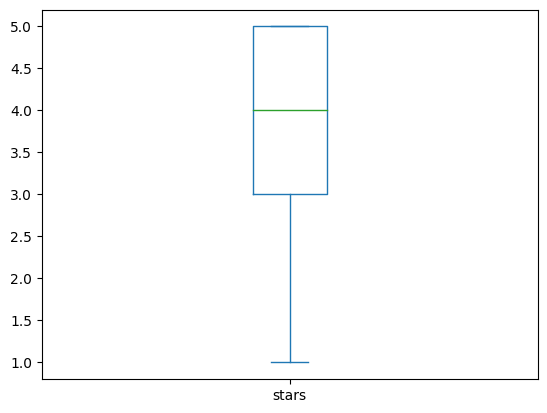

In [263]:
review_user_df.groupby('user_id')['stars'].mean().plot(kind='box')

In [264]:
# early reviews: within month or two after yelping since
youth_threshold = timedelta(days=60)
early_reviews = review_user_df[review_user_df.date - review_user_df.yelping_since < youth_threshold]

early_reviews[['date', 'yelping_since', 'stars', 'user_id']].sample(10)

early_reviews = early_reviews.groupby('user_id').agg(list)
early_reviews.reset_index(inplace=True)
early_reviews['count'] = early_reviews['name'].apply(lambda x: len(x))
early_reviews[early_reviews['count'] >= 3].sample(3)

,user_id,review_id,business_id,stars,date,text,useful,funny,cool,name,review_count,yelping_since,fans,average_stars,count
255,R0KVWeN9xR-F6j4z5k9wXQ,"[F3EDIZnRn4vinucX-lHxRA, cqjDIblHJ9TjmBW9BfRtT...","[Rj3wnYT1QAxpJlRT5mMc-g, 3TxhQKVNLKqRKITPrZQlG...","[4.0, 4.0, 4.0, 4.0, 1.0, 4.0]","[2006-08-01 00:00:00, 2006-07-29 00:00:00, 200...",[Good standard breakfast fare near Mill Avenue...,"[0, 0, 0, 0, 1, 0]","[1, 0, 0, 0, 3, 1]","[1, 0, 0, 0, 1, 1]","[Meridith, Meridith, Meridith, Meridith, Merid...","[439.0, 439.0, 439.0, 439.0, 439.0, 439.0]","[2006-07-02 15:38:27, 2006-07-02 15:38:27, 200...","[63.0, 63.0, 63.0, 63.0, 63.0, 63.0]","[3.640000104904175, 3.640000104904175, 3.64000...",6
171,HLaSqQMDVvlcFPGJL_kGCA,"[39ukJIrbqD1Pk5V16B5weA, csisdyW9lLEE2vMZgAzCP...","[VMPSdoBgJuyS9t_x_caTig, ues2rFe_hbRC7s232PX5Q...","[5.0, 2.0, 1.0, 2.0, 2.0]","[2005-03-03 00:00:00, 2005-04-22 00:00:00, 200...",[Easily my favorite place to eat in Madison. ...,"[1, 3, 0, 0, 3]","[0, 3, 0, 0, 0]","[0, 0, 0, 0, 0]","[Jeremy, Jeremy, Jeremy, Jeremy, Jeremy]","[179.0, 179.0, 179.0, 179.0, 179.0]","[2005-03-03 19:40:10, 2005-03-03 19:40:10, 200...","[2.0, 2.0, 2.0, 2.0, 2.0]","[3.569999933242798, 3.569999933242798, 3.56999...",5
548,y0ZU1w6YY4W-KtMeRXSYLg,"[cOSiHbITZhs5amHm7Y8JXg, xuKBj9Oq-WEkkZn2nISj0...","[lCjPw8i-bCAd8_W3yzQa8Q, hcVHqcbLqk6QQjITVQ7RT...","[5.0, 3.0, 4.0, 4.0, 4.0, 3.0, 3.0, 4.0]","[2008-12-04 00:00:00, 2008-12-12 00:00:00, 200...",[Fresh! Natural! Organic! And........cheap? Sa...,"[6, 2, 4, 4, 5, 2, 1, 1]","[1, 0, 4, 2, 0, 0, 1, 1]","[4, 1, 3, 3, 2, 1, 0, 0]","[Kim, Kim, Kim, Kim, Kim, Kim, Kim, Kim]","[231.0, 231.0, 231.0, 231.0, 231.0, 231.0, 231...","[2008-10-31 14:56:58, 2008-10-31 14:56:58, 200...","[10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]","[3.5799999237060547, 3.5799999237060547, 3.579...",8


In [265]:
review_bursts = review_user_df.groupby(['user_id', 'date']).agg(list)
review_bursts.reset_index(inplace=True)
review_bursts['count'] = review_bursts['name'].apply(lambda x: len(x))
review_bursts[review_bursts['count'] >= 3].sample(3)

,user_id,date,review_id,business_id,stars,text,useful,funny,cool,name,review_count,yelping_since,fans,average_stars,count
6715,qDi5XvihmkuTWLhaw3f3Fw,2007-06-21,"[Ca9VAAxXG_AsVCmYRkaWJw, xIsrA1CiBlyb36IL90XKU...","[FooKqQJ3UnsIG2slFPuLRA, AqpiBApzrd30LA-vmU3Rv...","[3.0, 4.0, 5.0]",[Las Vegas has attracted several famous delica...,"[1, 0, 5]","[0, 0, 3]","[0, 0, 3]","[Larry, Larry, Larry]","[135.0, 135.0, 135.0]","[2007-06-05 17:53:05, 2007-06-05 17:53:05, 200...","[8.0, 8.0, 8.0]","[3.5799999237060547, 3.5799999237060547, 3.579...",3
735,5Kbn1FjXmS7Jypz3_ybt_Q,2006-01-14,"[_mKKcQEcClgg69pLql-2CQ, gWWX-bdEpQXqUkVAbdn6H...","[VgGO13Fx7dQj4zg3IuVDLw, Dw4qOCZYT3ge2lGvXmet7...","[2.0, 4.0, 3.0, 4.0]",[Definitely a mixed crowd as stated before. D...,"[0, 0, 0, 2]","[0, 0, 0, 1]","[0, 0, 0, 1]","[Kelly, Kelly, Kelly, Kelly]","[91.0, 91.0, 91.0, 91.0]","[2006-01-14 04:33:56, 2006-01-14 04:33:56, 200...","[10.0, 10.0, 10.0, 10.0]","[4.03000020980835, 4.03000020980835, 4.0300002...",4
6697,q5afJ8gTV5TPEOkzyeJ_WQ,2012-07-18,"[Te6mPCPusEcQcV-aLC2WPA, KXEBwt1f83VzTumD446uZ...","[H8xL4KdQWTIhkoYI6Gv-AA, f4d8cyTwhx-HnsrC1Ws4L...","[1.0, 5.0, 5.0, 5.0]",[I wasn't even going to write a review but the...,"[2, 0, 3, 1]","[11, 0, 0, 0]","[0, 0, 1, 0]","[Kellie, Kellie, Kellie, Kellie]","[262.0, 262.0, 262.0, 262.0]","[2011-03-15 16:00:31, 2011-03-15 16:00:31, 201...","[19.0, 19.0, 19.0, 19.0]","[4.360000133514404, 4.360000133514404, 4.36000...",4


In [266]:
# ~14 years * ~50 weeks
bins_count = 700
review_user_df['date_bin'] = pd.cut(review_user_df['date'], bins=bins_count, labels=range(bins_count))

review_bursts_binned = review_user_df.groupby(['user_id', 'date_bin']).agg(list)
review_bursts_binned.reset_index(inplace=True)
review_bursts_binned = review_bursts_binned.dropna()
review_bursts_binned['count'] = review_bursts_binned['name'].apply(lambda x: len(x))
review_bursts_binned[review_bursts_binned['count'] >= 3].sample(3)

,user_id,date_bin,review_id,business_id,stars,date,text,useful,funny,cool,name,review_count,yelping_since,fans,average_stars,count
1181243,Ly-Vig99PPa2ySCDccRfxg,343,"[miPkRlct84EBROTzo-ya9g, -f3LAyX5h5vpxNFX3p707...","[q6igRYs2UTO-4nTwlttrAQ, 0jAexNHRHhkQv4zNYqenB...","[3.0, 2.0, 5.0]","[2011-11-03 00:00:00, 2011-11-01 00:00:00, 201...",[Pancheros is 50 feet from my house so it's gr...,"[0, 0, 2]","[0, 4, 1]","[0, 0, 0]","[Josh, Josh, Josh]","[111.0, 111.0, 111.0]","[2010-05-31 20:48:51, 2010-05-31 20:48:51, 201...","[4.0, 4.0, 4.0]","[3.950000047683716, 3.950000047683716, 3.95000...",3
57738,04J_q_VhSBItxNiEAN-gkA,338,"[S-FIMHAQwgWmZMEAwsWvXg, agJ9kXcqsKTwD_QOwS4MG...","[0jAexNHRHhkQv4zNYqenBA, Sy75QB18Sv-xNp8FoA8Kv...","[3.0, 4.0, 5.0]","[2011-09-26 00:00:00, 2011-09-26 00:00:00, 201...",[I would have given higher rating if based on ...,"[4, 3, 3]","[2, 1, 1]","[1, 1, 3]","[Nydia, Nydia, Nydia]","[473.0, 473.0, 473.0]","[2011-01-14 18:17:36, 2011-01-14 18:17:36, 201...","[133.0, 133.0, 133.0]","[3.9200000762939453, 3.9200000762939453, 3.920...",3
1214788,MbBhClrXyu8-Mk5wW5y8tg,288,"[FMpGaXgvt7w_iOc0O_r56Q, Wa3vDh5kzzkm6L3FBPSKI...","[J9f-9Prw2YVM-fiZqv2fmQ, kGL6bJ4cZUKdiwyUmezgi...","[3.0, 3.0, 4.0]","[2010-10-10 00:00:00, 2010-10-07 00:00:00, 201...",[The O. A staple for Pitt and CMU students. If...,"[0, 1, 2]","[0, 0, 0]","[0, 1, 2]","[Keith, Keith, Keith]","[565.0, 565.0, 565.0]","[2009-12-15 16:51:00, 2009-12-15 16:51:00, 200...","[31.0, 31.0, 31.0]","[3.359999895095825, 3.359999895095825, 3.35999...",3


In [267]:
early_reviewers = set(early_reviews['user_id'])
oneday_burst_reviewers = set(review_bursts['user_id'])
oneweek_burst_reviewers = set(review_bursts_binned['user_id'])

print(f'1d / 1w: {len(oneday_burst_reviewers.intersection(oneweek_burst_reviewers))}')
print(f'early / 1w: {len(early_reviewers.intersection(oneweek_burst_reviewers))}')
print(f'early / 1d: {len(early_reviewers.intersection(oneday_burst_reviewers))}')

1d / 1w: 4692
early / 1w: 558
early / 1d: 558


In [268]:
from data.paths.parquet_paths import BUSINESS
from data_analysis.utils import business

business_df = pd.read_parquet(str(BUSINESS))
business_df = business.prepare_business_df(business_df)
business_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, iBof5Tl8vrKISbi82tFEvQ to 9999
Data columns (total 51 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   name                        10000 non-null  object 
 1   address                     10000 non-null  object 
 2   city                        10000 non-null  object 
 3   state                       10000 non-null  object 
 4   postal_code                 10000 non-null  object 
 5   latitude                    10000 non-null  float32
 6   longitude                   10000 non-null  float32
 7   stars                       10000 non-null  float32
 8   review_count                10000 non-null  float64
 9   is_open                     10000 non-null  float64
 10  categories                  10000 non-null  object 
 11  hours                       7716 non-null   object 
 12  AcceptsInsurance            413 non-null    object 
 13  AgesAllowed     

In [269]:
# Searching for home state
# taking users activity
# grouping by user
# checking for the most visted / visited for longest time

review_place_df = review_user_df[['user_id', 'business_id', 'date']]
review_place_df = review_place_df.join(business_df[['city', 'state', 'latitude', 'longitude']], rsuffix='_business', on='business_id')
review_place_df = review_place_df.dropna()
review_place_df

,user_id,business_id,date,city,state,latitude,longitude
3,zEOuNc4K40aw-GE6y8RgIg,Y6FNieFd5UKhJ3a6FbQhyg,2014-07-28,Gilbert,AZ,33.378639,-111.755966
34,fJezNrc49UX9gONGNJ4YUQ,4gwh0q7JsdzHIm_pdYUlZg,2013-02-22,Scottsdale,AZ,33.539532,-111.924576
82,UYcmGbelzRa0Q6JqzLoguw,Er5XAY2UFGGqBHdqpeCFkA,2013-08-04,Las Vegas,NV,36.010628,-115.174904
87,whqfWVBj4x5EDboIVDOymQ,CsLQLiRoafpJPJSkNX2h5Q,2010-03-13,Charlotte,NC,35.194893,-80.767441
93,Y1ICO26IsN7i_1OVD0Inyw,GHs7grPeyVPwmiVKhhfMvg,2008-05-02,Glendale,AZ,33.534256,-112.261200
...,...,...,...,...,...,...,...
99827,Wmh9vK9LX-sxeuTb6vzM2A,36pB0QVVNZuOLV_UxosbAQ,2018-08-27,Montréal,QC,45.479313,-73.584496
99830,U13tLFucJNz1fNv_Xgdj0g,WCqcYtJ4rUxA4bIzjOfzqg,2013-05-11,Charlotte,NC,35.226147,-80.844231
99856,PYRIiQilTl1rkx83hm8ttA,LHXisknIbUy_XtdEQc7x9w,2014-05-13,Las Vegas,NV,36.060051,-115.164833
99892,SBsQvmEEYJsD6xeRzHxf8Q,aRqxT28Tdz2aDiZ7Vkyejw,2013-06-01,Toronto,ON,43.664177,-79.414963


In [270]:
state_mode = (review_place_df
    .groupby(['user_id'])['state']
    .agg(lambda x: pd.Series.mode(x)[0])
    .reset_index()
    .set_index('user_id'))
city_mode = (review_place_df
    .groupby(['user_id'])['city']
    .agg(lambda x: pd.Series.mode(x)[0])
    .reset_index()
    .set_index('user_id'))

user_home_byvisits = state_mode.join(city_mode, on='user_id')
user_home_byvisits.reset_index()

,user_id,state,city
0,---1lKK3aKOuomHnwAkAow,NV,Las Vegas
1,--RlSfc-QmcHFGHyX6aVjA,NV,Las Vegas
2,-1BrzE0pqO_EVw9SGzHEnw,NV,Las Vegas
3,-6J2VjbeLWAHsyAB8VN7bA,AZ,Glendale
4,-6iqrpnSPBW2plS8y7-cLA,NC,Charlotte
...,...,...,...
2750,zwmw_cNa5DzJotaFOHTvQg,AZ,Scottsdale
2751,zx6gq8IslnAwCyCUztXn1A,AZ,Scottsdale
2752,zy2ImADN9B0cvIRCC3d0Zg,AZ,Gilbert
2753,zyNGr5Tlg1rK1frevXCx2g,AZ,Scottsdale


In [271]:
# How to check by time?
# for each pair of reviews from same state/city count deltas between visits, max delta is homestate, homecity
from itertools import combinations

state_delta = review_place_df.groupby(['user_id', 'state']).apply(lambda x:
    sum(map(lambda dates: abs((dates[1] - dates[0]).days), combinations(x['date'], 2))))
    
state_mode_time = (state_delta.groupby(['user_id', 'state'])
    .max()
    .reset_index()[['user_id', 'state']]
    .drop_duplicates(['user_id'])
    .set_index('user_id'))

city_delta = review_place_df.groupby(['user_id', 'city']).apply(lambda x:
    sum(map(lambda dates: abs((dates[1] - dates[0]).days), combinations(x['date'], 2))))
city_mode_time = (city_delta.groupby(['user_id', 'city'])
    .max()
    .reset_index()[['user_id', 'city']]
    .drop_duplicates(['user_id'])
    .set_index('user_id'))

user_home_bydelta = state_mode_time.join(city_mode_time, on='user_id')
user_home_bydelta.reset_index()

,user_id,state,city
0,---1lKK3aKOuomHnwAkAow,NV,Las Vegas
1,--RlSfc-QmcHFGHyX6aVjA,NV,Las Vegas
2,-1BrzE0pqO_EVw9SGzHEnw,NV,Las Vegas
3,-6J2VjbeLWAHsyAB8VN7bA,AZ,Glendale
4,-6iqrpnSPBW2plS8y7-cLA,NC,Charlotte
...,...,...,...
2750,zwmw_cNa5DzJotaFOHTvQg,AZ,Scottsdale
2751,zx6gq8IslnAwCyCUztXn1A,AZ,Scottsdale
2752,zy2ImADN9B0cvIRCC3d0Zg,AZ,Gilbert
2753,zyNGr5Tlg1rK1frevXCx2g,AZ,Scottsdale


In [272]:
user_home_byvisits.compare(user_home_bydelta, keep_shape=True).dropna()

state              city           
                        self other        self      other
user_id                                                  
37HswRimgBEf7_US-c3CDA    NV    NC   Las Vegas  Charlotte
CxDOIDnH8gp9KXzpBHJYXw    ON    OH     Markham  Cleveland
U4INQZOPSUaj8hMjLlZ3KA    NV    AZ   Las Vegas  Henderson
hLVq7VSJBHZwqurwWoCmpg    PA    NV  Pittsburgh  Las Vegas

In [273]:
review_user_df = review_user_df.join(business_df['state'], on='business_id')
review_user_df['state'].dropna()

3        AZ
34       AZ
82       NV
87       NC
93       AZ
         ..
99827    QC
99830    NC
99856    NV
99892    ON
99944    PA
Name: state, Length: 4023, dtype: object

In [274]:
review_user_df = review_user_df.join(user_home_byvisits['state'], on='user_id', rsuffix='_user')
review_user_df['state_user'].dropna()

3        AZ
34       AZ
36       AZ
66       NV
68       AZ
         ..
99916    AZ
99920    NC
99924    AZ
99935    NV
99944    PA
Name: state_user, Length: 6044, dtype: object

In [275]:
review_user_df['origin'] = review_user_df.apply(lambda x:
    'unknown' if x.state is None or x.state_user is None else 
    'local' if x.state == x.state_user 
    else 'tourist', 
    axis=1)

review_user_df = review_user_df.drop(['state', 'state_user'], axis=1)

In [276]:
review_user_df[['review_id', 'business_id', 'origin']].sample(10)

,review_id,business_id,origin
53723,d6MNIgbZzVWvD1ibo6XyDA,0EUohlWGBPnIgzCULyWl7g,local
48887,EJenzAjPwwN8RZXrPSxEjA,FodnfLi_ezVmL5DcrxnI3Q,local
50320,f_J_KsqZyvj7GiM4ImKBng,4qG3Gh8QyugC1XvoTlmgcQ,tourist
16016,Fx34YwTqTcjB_bbC19aoIg,Rb2s2-2kIvbPXnPEuM_OBg,local
28368,H55hzj2SeDMboAjf9lUvRA,Zmfq3DVhHdtVChhSxzoUHw,tourist
3062,9jb8F7E9szba_UwwjDltkw,7uGsMlo8_uIZIITKfhEARA,local
6549,DD9NHdsVW7CM3VQ3W_glVg,atNpoWy_XrhT9EUIEP6azg,local
40375,cxsrk7lSClYHmwmKXkfVlw,xYIjSJZbiK0nDxdC8LFwJw,local
82417,NHglvYOsO4yUI0ITdR-c3Q,46Ld9Qc9nAx_A0jwclNZiw,tourist
19625,fNhsDQz1l80vLf_AL-8H6A,K-iqIqMTTvESaAz2KgwulA,local


In [277]:
local_reviews = review_user_df[review_user_df['origin'] == 'local'][['business_id', 'stars']]
local_reviews

,business_id,stars
3,Y6FNieFd5UKhJ3a6FbQhyg,4.0
34,4gwh0q7JsdzHIm_pdYUlZg,5.0
82,Er5XAY2UFGGqBHdqpeCFkA,4.0
87,CsLQLiRoafpJPJSkNX2h5Q,3.0
93,GHs7grPeyVPwmiVKhhfMvg,2.0
...,...,...
99827,36pB0QVVNZuOLV_UxosbAQ,5.0
99830,WCqcYtJ4rUxA4bIzjOfzqg,4.0
99856,LHXisknIbUy_XtdEQc7x9w,4.0
99892,aRqxT28Tdz2aDiZ7Vkyejw,4.0


In [278]:
business_df['local_stars'] = business_df.index.to_series().apply(lambda x: 
    local_reviews[local_reviews['business_id'] == x]['stars'].mean())
business_df['local_stars'].sample(10)

7964                      NaN
695                       NaN
yQXG2KepKmU7A1LiEQYAcw    NaN
kRtv_n9nenukbmTFE5tgNg    NaN
4VOxaNfc-YnaT1xamBOKUw    NaN
3550                      NaN
3375                      NaN
5606                      NaN
AnNc37ZrSbnA-IjchurfBg    4.0
9910                      NaN
Name: local_stars, dtype: float64

In [279]:
tourist_reviews = review_user_df[review_user_df['origin'] == 'tourist'][['business_id', 'stars']]
tourist_reviews

,business_id,stars
7,0TBTV3q6QXCn9vNhy3Xi2w,4.0
21,XZbuPXdyA0ZtTu3AzqtQhg,4.0
36,bAZnIuqxB9RHu-Mz_HBeJg,4.0
47,u_vPjx925UPEG9DFOAAvFQ,3.0
66,p0iEUamJVp_QpaheE-Nz_g,4.0
...,...,...
99914,-zbcosKSMGDhaZYN-CrcVA,4.0
99916,_4Gpn_NIM94D9OFucgfaJQ,3.0
99920,oLeNHOEqeuFFgDTprUNXqg,3.0
99924,I6ICIIZfZsp_J9hHmfhWhQ,5.0


In [280]:
business_df['tourist_stars'] = business_df.index.to_series().apply(lambda x: 
    tourist_reviews[tourist_reviews['business_id'] == x]['stars'].mean())
business_df['tourist_stars'].sample(10)

6110                     NaN
BgDjGWbaoSE73U-WaKLOxg   NaN
2IbXNp96PAZzjpzytN9vVg   NaN
SwqXNCoaqhX5Oj1tKbrxkw   NaN
EUhjQecCVsyxPXE20DFsaw   NaN
1816                     NaN
7JcU28B3jWAWeqkabD_S1g   NaN
9854                     NaN
dn-OW4H367wyfG6dIH61Bw   NaN
v9Rs-7znDmusELWjbaJslA   NaN
Name: tourist_stars, dtype: float64

In [281]:
business_df[['stars', 'local_stars', 'tourist_stars']].dropna().sample(10)

,stars,local_stars,tourist_stars
FooKqQJ3UnsIG2slFPuLRA,3.5,3.000000,5.00
CK-Gv3vqIlWOrKP4fhT8_g,4.0,3.818182,4.00
V3Hz6fC1w4TQJj-PkXMiRw,2.5,3.000000,3.00
U9aA5H13y7t9xWnoQslV0Q,2.5,2.863636,2.00
QzuamBC7eQx8oHlg6n_qIA,3.0,4.000000,5.00
5DDumAHRKumv3gZiPKW6iw,4.5,4.777778,4.00
d6VYQbeTZ_WdD8Uuhh35dg,4.0,3.666667,4.00
XBRCMc3rcvcRXrB3p-o9yA,4.0,5.000000,4.00
UT6L3b7Zll_nvRidijiDSA,4.0,3.300000,4.00
rcaPajgKOJC2vo_l3xa42A,4.0,4.130890,3.75
